# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [ ]:
!pip install torch-summary

In [ ]:
!pip install pthflops

In [ ]:
import random
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional
import torch.nn as nn
import torch
from torch.optim import SGD
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchsummary import summary
import numpy as np
from torch.utils.data import ConcatDataset
from torchvision.transforms import v2
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
from pthflops import count_ops
import seaborn as sns
import pandas as pd
import optuna


plt.style.use('ggplot')
sns.set(style='whitegrid')

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

---
---

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: int
            The seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


## Data Pre-processing

### Data Loading

First, we load both train and validation datasets, performing a downsampling of the images to 224x224 to ensure homogenous resolution. We also apply  `CenterCrop` to preserve aspect ratio.

In [ ]:
tsfms = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])

train_dataset = GroceryStoreDataset('train', tsfms)
val_dataset = GroceryStoreDataset('val', tsfms)
n_classes = train_dataset.get_num_classes()
input_dim = train_dataset[0][0].size()

### Data Exploration

This section provides an overview of the dataset. We visualize class distributions to ensure similarity between training and validation sets.


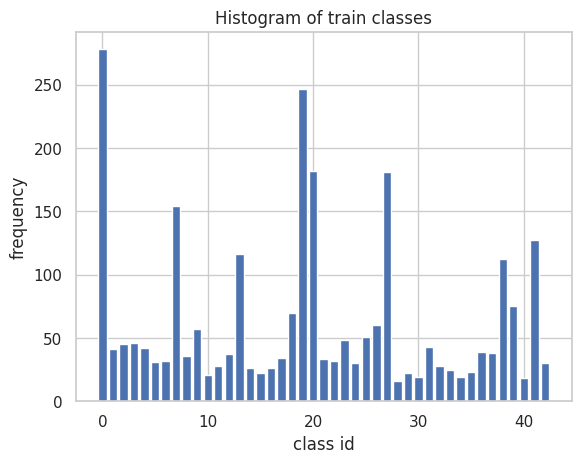

In [ ]:
labels, counts = np.unique(train_dataset.labels, return_counts=True)
plt.bar(labels, counts)
plt.title('Histogram of train classes')
plt.xlabel('class id')
plt.ylabel('frequency')
plt.show()

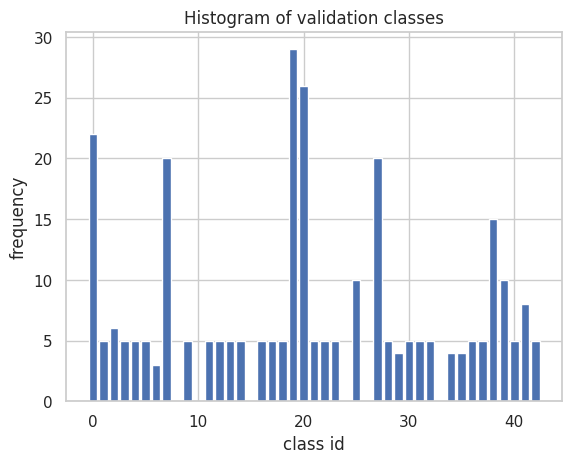

In [ ]:
labels, counts = np.unique(val_dataset.labels, return_counts=True)
plt.bar(labels, counts)
plt.title('Histogram of validation classes')
plt.xlabel('class id')
plt.ylabel('frequency')
plt.show()

### Data Augmentation

We perform augmentation by first applying multi-scale augmentation <a href="#resnet">[2]</a> to enhance model's ability to generalize across different scales. This is  followed by geometric transformations such as `RandomHorizontalFlip` and `RandomAffine` which add robustness to positional variations. Finally `ColorJitter` is used to ensure robustness against illumination changes.
We also experimented with *FancyPCA* for color augmentation, as in <a href="#alexnet">[3]</a>,  but the results were not optimal and did not improve the model’s performance.

In [ ]:
augmentation = T.Compose([
    v2.RandomResize(256,480),
    T.RandomCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation((-7,7)),
    v2.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
])


augmented = GroceryStoreDataset('train', augmentation)
augmented_dataset = ConcatDataset([train_dataset, augmented])

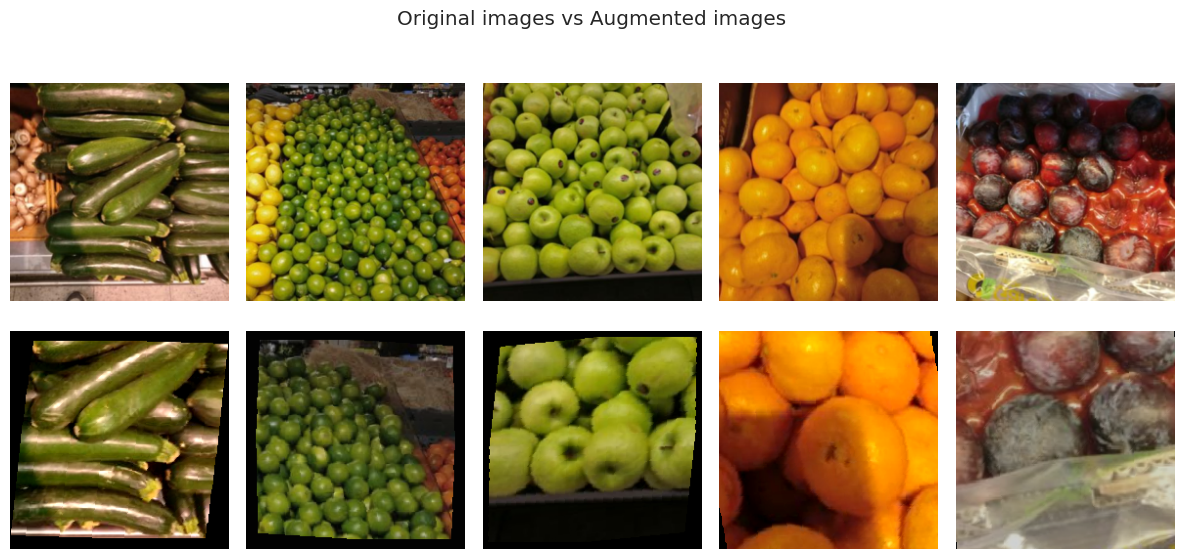

In [ ]:
idx = random.sample(range(len(train_dataset)),5)
fig, ax = plt.subplots(2,5,figsize=(12,6))
fig.suptitle('Original images vs Augmented images')
for i in range(5):
    ax[0,i].imshow(train_dataset[idx[i]][0].permute(1, 2, 0))
    ax[0,i].axis('off')
    ax[1,i].imshow(augmented[idx[i]][0].permute(1, 2, 0))
    ax[1,i].axis('off')
plt.tight_layout()
plt.show()


We compute the mean and standard deviation from our augmented dataset and use these values for **normalization**. We thought that this approach was more appropriate than using ImageNet’s statistics because it ensures that the normalization reflects the actual distribution of our data. By normalizing with our own dataset’s statistics we improve the model’s performance and training stability.

In [ ]:
def compute_mean(dataset):
    mean = np.zeros((3,),dtype=np.float32)
    for img, label in dataset:
        mean += np.sum(np.array(img), axis=(1,2))
    mean /= (len(dataset)*224*224)
    return mean

def compute_std(dataset, mean):
    std = np.zeros((3,),dtype=np.float32)
    mean = mean.reshape((3,1,1))
    for img, label in train_dataset:
        img = np.array(img)
        std += np.sum((img-mean)**2, axis=(1,2))
    std /= (len(dataset)*224*224)
    std = np.sqrt(std)
    return std

In [ ]:
mean = compute_mean(augmented_dataset)
std = compute_std(augmented_dataset, mean)
tsfms_norm = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

augmentation_norm = T.Compose([
    v2.RandomResize(256,480),
    T.RandomCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation((-7,7)),
    v2.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

val_dataset = GroceryStoreDataset('val', tsfms_norm)
train_dataset = GroceryStoreDataset('train', tsfms_norm)
augmented = GroceryStoreDataset('train',augmentation_norm)
augmented_dataset = ConcatDataset([train_dataset, augmented])

### Setting up the configuration parameters

In [ ]:
cfg = {
    'optimizer': torch.optim.SGD,
    'optimizer_params': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.001},
    'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'scheduler_params': {'mode': 'min', 'factor': 0.1, 'patience': 5},
    'batch_size': 64,
    'epochs': 100,
    'patience': 15
}

def get_num_parameters(model: Tensor) -> int:
    return sum(p.numel() for p in model.parameters())

## Training

In [ ]:
train_dl = DataLoader(augmented_dataset, batch_size=cfg['batch_size'], shuffle=True, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=cfg['batch_size'])
metrics = {}
parameters = []
flops = []

We define functions to compute accuracy and manage the model’s training, including *Early Stopping*, validation, and restoring the best model weights.

In [ ]:
def ncorrect(scores: Tensor, y: Tensor) -> Tensor:
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores: Tensor, y: Tensor) -> Tensor:
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model: Tensor,
               train_dl: DataLoader,
               epochs: int,
               patience: int,
               opt: torch.optim.Optimizer,
               scheduler: Optional[torch.optim.lr_scheduler.LRScheduler]=None,
               val_dl: Optional[DataLoader]=None,
               verbose: bool=False) -> tuple[List[float], ...] :
    """Training process.

    Args:
        model: torch.Tensor
            Model to be trained.

        train_dl: DataLoader
            Set of train samples divided into batches.

        epochs: int
            Maximum number of epochs.

        patience: int
            Number of epochs after which EarlyStopping is triggered.

        opt: torch.optim.Optimizer
            Optimizer to be used.

        scheduler: (torch.optim.LRScheduler, optional)
            Optional scheduler to reduce the learning rate during training.

        val_dl: (Dataloader, optional)
            Set of validation samples divided into batches.

        verbose: bool
            Whether or not to print statistics at the end of each epoch.
    """

    best_val_acc = 0
    best_params = None
    curr_patience = 0
    total_train_loss = []
    total_val_loss = []
    total_train_acc = []
    total_val_acc = []
    best_val_loss = float('inf')  # Initialize best_val_loss


    for e in tqdm(range(epochs), desc='Training progress'):
        if curr_patience == patience:
            if verbose:
                print(f"\nEarly stopping at epoch {e+1} with best val accuracy: {best_val_acc}")
            break

        # Training Phase
        model.train()
        train_loss = 0.0
        train_acc = 0
        train_samples = 0

        for imgs, labels in train_dl:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels, label_smoothing=0.1)

            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Statistics
            train_loss += loss.item() * imgs.size(0)
            train_acc += ncorrect(scores, labels).item()
            train_samples += imgs.size(0)

        epoch_train_loss = train_loss / train_samples
        epoch_train_acc = train_acc / train_samples
        total_train_loss.append(epoch_train_loss)
        total_train_acc.append(epoch_train_acc)

        # Validation Phase
        if val_dl is not None:
            model.eval()
            val_loss = 0.0
            val_acc = 0
            val_samples = 0

            with torch.no_grad():
                for imgs, labels in val_dl:
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    val_scores = model(imgs)
                    loss = F.cross_entropy(val_scores, labels)

                    val_loss += loss.item() * imgs.size(0)
                    val_acc += ncorrect(val_scores, labels).item()
                    val_samples += imgs.size(0)

            epoch_val_loss = val_loss / val_samples
            epoch_val_acc = val_acc / val_samples
            total_val_loss.append(epoch_val_loss)
            total_val_acc.append(epoch_val_acc)

            # Step the scheduler with the validation loss
            if scheduler:
                scheduler.step(epoch_val_loss)

            # Early Stopping
            if best_val_acc <  epoch_val_acc:
                best_val_acc = epoch_val_acc
                best_params = model.state_dict()
                torch.save(model.state_dict(), "best_model.pth")
                curr_patience = 0
            else:
                curr_patience += 1

            if verbose and e % 5 == 0:
                print(f"Epoch {e+1}/{epochs}: "
                      f"Train Loss: {epoch_train_loss:.3f}, "
                      f"Train Acc: {epoch_train_acc:.3f}, "
                      f"Val Loss: {epoch_val_loss:.3f}, "
                      f"Val Acc: {epoch_val_acc:.3f}")
    model.load_state_dict(torch.load("best_model.pth", weights_only=True))
    return total_val_loss, total_val_acc, total_train_loss, total_train_acc

The `ConvBlock` class creates a block of two convolutional layers, each followed by batch normalization and ReLU activation, inspired by VGG architecture <a href="#vgg">[4]</a>.

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    """
    Convolutional block consisting of one or more Conv2d layers followed by BatchNorm2d and ReLU activation.
    """
    def __init__(self, in_channels: int, out_channels: int, num_convs: int, use_batchnorm: bool =True):
        super(ConvBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

            # Update in_channels for the next convolution
            in_channels = out_channels
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

The `GroceryModelFull` class defines a custom convolutional neural network inspired by the VGG architecture. It consists of three convolutional blocks with increasing channel sizes, each followed by a max pooling layer to reduce spatial dimensions. Unlike VGG, which uses fully connected layers that create an imbalanced distribution of parameters between the backbone and the classification head, this model employs *adaptive average pooling*.

In [ ]:
class GroceryModelFull(nn.Module):
    """
    Custom convolutional neural network inspired by VGG architecture.
    """
    def __init__(self, num_classes):
        super(GroceryModelFull, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            ConvBlock(in_channels=3, out_channels=64, num_convs=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            # Block 2
            ConvBlock(in_channels=64, out_channels=128, num_convs=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            # Block 3
            ConvBlock(in_channels=128, out_channels=256, num_convs=2),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model_full = GroceryModelFull(n_classes)
parameters.append(get_num_parameters(model_full))
flops.append(count_ops(model_full, torch.rand(1,3,224,224), print_readable=False)[0]*1e-09)
summary(model_full, input_dim);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─ConvBlock: 2-1                    [-1, 64, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 64, 224, 224]        38,976
|    └─MaxPool2d: 2-2                    [-1, 64, 112, 112]        --
|    └─ConvBlock: 2-3                    [-1, 128, 112, 112]       --
|    |    └─Sequential: 3-2              [-1, 128, 112, 112]       221,952
|    └─MaxPool2d: 2-4                    [-1, 128, 56, 56]         --
|    └─ConvBlock: 2-5                    [-1, 256, 56, 56]         --
|    |    └─Sequential: 3-3              [-1, 256, 56, 56]         886,272
|    └─AdaptiveAvgPool2d: 2-6            [-1, 256, 1, 1]           --
├─Sequential: 1-2                        [-1, 43]                  --
|    └─Flatten: 2-7                      [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 43]                  11,0

In [ ]:
model_full.to(device)

GroceryModelFull(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
# Initialize the optimizer and scheduler
optimizer = cfg['optimizer'](model_full.parameters(), **cfg['optimizer_params'])
scheduler = cfg['scheduler'](optimizer, **cfg['scheduler_params'])

#Start training
metrics['Full'] = train_loop(
    model_full,
    train_dl,
    cfg['epochs'],
    cfg['patience'],
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 2.787, Train Acc: 0.325, Val Loss: 2.514, Val Acc: 0.297

Epoch 6/100: Train Loss: 1.750, Train Acc: 0.636, Val Loss: 1.642, Val Acc: 0.517

Epoch 11/100: Train Loss: 1.464, Train Acc: 0.763, Val Loss: 1.348, Val Acc: 0.574

Epoch 16/100: Train Loss: 1.286, Train Acc: 0.842, Val Loss: 1.395, Val Acc: 0.608

Epoch 21/100: Train Loss: 1.141, Train Acc: 0.903, Val Loss: 1.164, Val Acc: 0.689

Epoch 26/100: Train Loss: 1.110, Train Acc: 0.911, Val Loss: 1.160, Val Acc: 0.726

Epoch 31/100: Train Loss: 1.092, Train Acc: 0.915, Val Loss: 1.155, Val Acc: 0.723

Epoch 36/100: Train Loss: 1.068, Train Acc: 0.926, Val Loss: 1.103, Val Acc: 0.720

Epoch 41/100: Train Loss: 1.062, Train Acc: 0.922, Val Loss: 1.146, Val Acc: 0.726

Epoch 46/100: Train Loss: 1.036, Train Acc: 0.937, Val Loss: 1.118, Val Acc: 0.736

Epoch 51/100: Train Loss: 1.031, Train Acc: 0.938, Val Loss: 1.115, Val Acc: 0.736

Epoch 56/100: Train Loss: 1.038, Train Acc: 0.939, Val Loss: 1.126, Val Acc: 0

## Ablation Study

To evaluate the impact of different architectural choices on model performance we conducted an ablation study by creating various versions of the base model with modifications to key components. Each version targets a specific aspect of the model’s structure, allowing us to isolate and assess its effect on learning and generalization.

The versions we tested are the following:

- **GroceryModelNoBN**: Base model version without batch normalization. Purpose: Evaluate the impact of batch normalization on model performance.

- **GroceryModelLessChannels**: Model with reduced channels in each block. Purpose: Assess the effect of reducing channels (and thus parameters) on learning and generalization.

- **GroceryModelLessConvs**: Model with a single convolution per block instead of two. Purpose: Determine the effect of reducing complexity by limiting the number of convolutions in each block.

- **GroceryModelLessBlocks**: Model with only two convolutional blocks instead of three. Purpose: Test the impact of reducing the number of convolutional blocks on feature extraction capacity.

In each variant the classifier head remains unchanged.

In [ ]:
class GroceryModelNoBN(nn.Module):
    """
    GroceryModel without batch norm.
    """
    def __init__(self, num_classes):
        super(GroceryModelNoBN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            ConvBlock(in_channels=3, out_channels=64, num_convs=2, use_batchnorm=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            ConvBlock(in_channels=64, out_channels=128, num_convs=2, use_batchnorm=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            ConvBlock(in_channels=128, out_channels=256, num_convs=2, use_batchnorm=False),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model_noBN = GroceryModelNoBN(n_classes)
parameters.append(get_num_parameters(model_noBN))
flops.append(count_ops(model_noBN, torch.rand(1,3,224,224), print_readable=False)[0]*1e-09)
summary(model_noBN, input_dim);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─ConvBlock: 2-1                    [-1, 64, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 64, 224, 224]        38,720
|    └─MaxPool2d: 2-2                    [-1, 64, 112, 112]        --
|    └─ConvBlock: 2-3                    [-1, 128, 112, 112]       --
|    |    └─Sequential: 3-2              [-1, 128, 112, 112]       221,440
|    └─MaxPool2d: 2-4                    [-1, 128, 56, 56]         --
|    └─ConvBlock: 2-5                    [-1, 256, 56, 56]         --
|    |    └─Sequential: 3-3              [-1, 256, 56, 56]         885,248
|    └─AdaptiveAvgPool2d: 2-6            [-1, 256, 1, 1]           --
├─Sequential: 1-2                        [-1, 43]                  --
|    └─Flatten: 2-7                      [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 43]                  11,0

In [ ]:
model_noBN.to(device)

GroceryModelNoBN(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [ ]:
# Initialize the optimizer and scheduler
optimizer = cfg['optimizer'](model_noBN.parameters(), **cfg['optimizer_params'])
scheduler = cfg['scheduler'](optimizer, **cfg['scheduler_params'])

#Start training
metrics['No batch norm'] = train_loop(
    model_noBN,
    train_dl,
    cfg['epochs'],
    cfg['patience'],
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 3.628, Train Acc: 0.093, Val Loss: 3.513, Val Acc: 0.068

Epoch 6/100: Train Loss: 2.794, Train Acc: 0.283, Val Loss: 2.758, Val Acc: 0.233

Epoch 11/100: Train Loss: 2.424, Train Acc: 0.387, Val Loss: 2.257, Val Acc: 0.402

Epoch 16/100: Train Loss: 2.189, Train Acc: 0.464, Val Loss: 2.168, Val Acc: 0.345

Epoch 21/100: Train Loss: 1.992, Train Acc: 0.543, Val Loss: 1.975, Val Acc: 0.405

Epoch 26/100: Train Loss: 1.853, Train Acc: 0.608, Val Loss: 1.912, Val Acc: 0.432

Epoch 31/100: Train Loss: 1.670, Train Acc: 0.684, Val Loss: 1.752, Val Acc: 0.537

Epoch 36/100: Train Loss: 1.555, Train Acc: 0.730, Val Loss: 1.736, Val Acc: 0.503

Epoch 41/100: Train Loss: 1.460, Train Acc: 0.767, Val Loss: 1.610, Val Acc: 0.551

Epoch 46/100: Train Loss: 1.376, Train Acc: 0.804, Val Loss: 1.661, Val Acc: 0.507

Epoch 51/100: Train Loss: 1.170, Train Acc: 0.894, Val Loss: 1.451, Val Acc: 0.588

Epoch 56/100: Train Loss: 1.140, Train Acc: 0.903, Val Loss: 1.445, Val Acc: 0

In [ ]:
class GroceryModelLessChannels(nn.Module):
    """
    GroceryModel with less channels for each block.
    """
    def __init__(self, num_classes):
        super(GroceryModelLessChannels, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            ConvBlock(in_channels=3, out_channels=32, num_convs=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            ConvBlock(in_channels=32, out_channels=64, num_convs=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            ConvBlock(in_channels=64, out_channels=128, num_convs=2),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model_less_channels = GroceryModelLessChannels(n_classes)
parameters.append(get_num_parameters(model_less_channels))
flops.append(count_ops(model_less_channels, torch.rand(1,3,224,224), print_readable=False)[0]*1e-09)
summary(model_less_channels, input_dim);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 1, 1]           --
|    └─ConvBlock: 2-1                    [-1, 32, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 32, 224, 224]        10,272
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─ConvBlock: 2-3                    [-1, 64, 112, 112]        --
|    |    └─Sequential: 3-2              [-1, 64, 112, 112]        55,680
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─ConvBlock: 2-5                    [-1, 128, 56, 56]         --
|    |    └─Sequential: 3-3              [-1, 128, 56, 56]         221,952
|    └─AdaptiveAvgPool2d: 2-6            [-1, 128, 1, 1]           --
├─Sequential: 1-2                        [-1, 43]                  --
|    └─Flatten: 2-7                      [-1, 128]                 --
|    └─Linear: 2-8                       [-1, 43]                  5,547

In [ ]:
model_less_channels.to(device)

GroceryModelLessChannels(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
# Initialize the optimizer and scheduler
optimizer = cfg['optimizer'](model_less_channels.parameters(), **cfg['optimizer_params'])
scheduler = cfg['scheduler'](optimizer, **cfg['scheduler_params'])

#Start training
metrics['Less channels'] = train_loop(
    model_less_channels,
    train_dl,
    cfg['epochs'],
    cfg['patience'],
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 2.999, Train Acc: 0.273, Val Loss: 2.662, Val Acc: 0.318

Epoch 6/100: Train Loss: 1.981, Train Acc: 0.537, Val Loss: 2.015, Val Acc: 0.426

Epoch 11/100: Train Loss: 1.716, Train Acc: 0.654, Val Loss: 1.704, Val Acc: 0.574

Epoch 16/100: Train Loss: 1.545, Train Acc: 0.732, Val Loss: 1.520, Val Acc: 0.561

Epoch 21/100: Train Loss: 1.381, Train Acc: 0.801, Val Loss: 1.736, Val Acc: 0.527

Epoch 26/100: Train Loss: 1.316, Train Acc: 0.831, Val Loss: 1.329, Val Acc: 0.642

Epoch 31/100: Train Loss: 1.210, Train Acc: 0.868, Val Loss: 1.397, Val Acc: 0.632

Epoch 36/100: Train Loss: 1.089, Train Acc: 0.920, Val Loss: 1.233, Val Acc: 0.703

Epoch 41/100: Train Loss: 1.074, Train Acc: 0.925, Val Loss: 1.205, Val Acc: 0.703

Epoch 46/100: Train Loss: 1.068, Train Acc: 0.931, Val Loss: 1.182, Val Acc: 0.713

Epoch 51/100: Train Loss: 1.057, Train Acc: 0.931, Val Loss: 1.222, Val Acc: 0.706

Epoch 56/100: Train Loss: 1.053, Train Acc: 0.935, Val Loss: 1.220, Val Acc: 0

In [ ]:
class GroceryModelLessConvs(nn.Module):
    """
    GroceryModel with only one convolution for each block.
    """
    def __init__(self, num_classes):
        super(GroceryModelLessConvs, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            ConvBlock(in_channels=3, out_channels=64, num_convs=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            ConvBlock(in_channels=64, out_channels=128, num_convs=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            ConvBlock(in_channels=128, out_channels=256, num_convs=1),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model_less_convs = GroceryModelLessConvs(n_classes)
parameters.append(get_num_parameters(model_less_convs))
flops.append(count_ops(model_less_convs, torch.rand(1,3,224,224), print_readable=False)[0]*1e-09)
summary(model_less_convs, input_dim);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─ConvBlock: 2-1                    [-1, 64, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 64, 224, 224]        1,920
|    └─MaxPool2d: 2-2                    [-1, 64, 112, 112]        --
|    └─ConvBlock: 2-3                    [-1, 128, 112, 112]       --
|    |    └─Sequential: 3-2              [-1, 128, 112, 112]       74,112
|    └─MaxPool2d: 2-4                    [-1, 128, 56, 56]         --
|    └─ConvBlock: 2-5                    [-1, 256, 56, 56]         --
|    |    └─Sequential: 3-3              [-1, 256, 56, 56]         295,680
|    └─AdaptiveAvgPool2d: 2-6            [-1, 256, 1, 1]           --
├─Sequential: 1-2                        [-1, 43]                  --
|    └─Flatten: 2-7                      [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 43]                  11,051

In [ ]:
model_less_convs.to(device)

GroceryModelLessConvs(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True

In [ ]:
# Initialize the optimizer and scheduler
optimizer = cfg['optimizer'](model_less_convs.parameters(), **cfg['optimizer_params'])
scheduler = cfg['scheduler'](optimizer, **cfg['scheduler_params'])

#Start training
metrics['Less convs'] = train_loop(
    model_less_convs,
    train_dl,
    cfg['epochs'],
    cfg['patience'],
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 2.929, Train Acc: 0.283, Val Loss: 2.643, Val Acc: 0.291

Epoch 6/100: Train Loss: 2.057, Train Acc: 0.518, Val Loss: 2.048, Val Acc: 0.378

Epoch 11/100: Train Loss: 1.823, Train Acc: 0.617, Val Loss: 1.849, Val Acc: 0.443

Epoch 16/100: Train Loss: 1.679, Train Acc: 0.682, Val Loss: 1.711, Val Acc: 0.456

Epoch 21/100: Train Loss: 1.569, Train Acc: 0.737, Val Loss: 1.579, Val Acc: 0.544

Epoch 26/100: Train Loss: 1.495, Train Acc: 0.765, Val Loss: 1.474, Val Acc: 0.601

Epoch 31/100: Train Loss: 1.410, Train Acc: 0.800, Val Loss: 1.545, Val Acc: 0.571

Epoch 36/100: Train Loss: 1.381, Train Acc: 0.809, Val Loss: 1.405, Val Acc: 0.571



Early stopping at epoch 39 with best val accuracy: 0.6047297297297297


In [ ]:
class GroceryModelLessBlocks(nn.Module):
    """
    GroceryModel with only two blocks.
    """
    def __init__(self, num_classes):
        super(GroceryModelLessBlocks, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            ConvBlock(in_channels=3, out_channels=64, num_convs=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            ConvBlock(in_channels=64, out_channels=128, num_convs=2),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model_less_blocks = GroceryModelLessBlocks(n_classes)
parameters.append(get_num_parameters(model_less_blocks))
flops.append(count_ops(model_less_blocks, torch.rand(1,3,224,224), print_readable=False)[0]*1e-09)
summary(model_less_blocks, input_dim);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 1, 1]           --
|    └─ConvBlock: 2-1                    [-1, 64, 224, 224]        --
|    |    └─Sequential: 3-1              [-1, 64, 224, 224]        38,976
|    └─MaxPool2d: 2-2                    [-1, 64, 112, 112]        --
|    └─ConvBlock: 2-3                    [-1, 128, 112, 112]       --
|    |    └─Sequential: 3-2              [-1, 128, 112, 112]       221,952
|    └─AdaptiveAvgPool2d: 2-4            [-1, 128, 1, 1]           --
├─Sequential: 1-2                        [-1, 43]                  --
|    └─Flatten: 2-5                      [-1, 128]                 --
|    └─Linear: 2-6                       [-1, 43]                  5,547
Total params: 266,475
Trainable params: 266,475
Non-trainable params: 0
Total mult-adds (G): 4.71
Input size (MB): 0.57
Forward/backward pass size (MB): 147.00
Params size (MB): 1.02
Estimated Total Size (MB): 148

In [ ]:
model_less_blocks.to(device)

GroceryModelLessBlocks(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# Initialize the optimizer and scheduler
optimizer = cfg['optimizer'](model_less_blocks.parameters(), **cfg['optimizer_params'])
scheduler = cfg['scheduler'](optimizer, **cfg['scheduler_params'])

#Start training
metrics['Less blocks'] = train_loop(
    model_less_blocks,
    train_dl,
    cfg['epochs'],
    cfg['patience'],
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 3.014, Train Acc: 0.262, Val Loss: 2.786, Val Acc: 0.186

Epoch 6/100: Train Loss: 2.125, Train Acc: 0.486, Val Loss: 2.230, Val Acc: 0.368

Epoch 11/100: Train Loss: 1.883, Train Acc: 0.576, Val Loss: 1.966, Val Acc: 0.443

Epoch 16/100: Train Loss: 1.735, Train Acc: 0.649, Val Loss: 1.673, Val Acc: 0.517

Epoch 21/100: Train Loss: 1.609, Train Acc: 0.716, Val Loss: 1.680, Val Acc: 0.470

Epoch 26/100: Train Loss: 1.510, Train Acc: 0.747, Val Loss: 1.665, Val Acc: 0.541

Epoch 31/100: Train Loss: 1.384, Train Acc: 0.812, Val Loss: 1.382, Val Acc: 0.598

Epoch 36/100: Train Loss: 1.365, Train Acc: 0.826, Val Loss: 1.377, Val Acc: 0.618

Epoch 41/100: Train Loss: 1.345, Train Acc: 0.836, Val Loss: 1.352, Val Acc: 0.625



Early stopping at epoch 46 with best val accuracy: 0.6486486486486487


In [ ]:
with open("/kaggle/input/metrics-new/metrics_new.json", "w") as outfile:
    json.dump(metrics, outfile)

In [ ]:
with open('/kaggle/input/metrics-new/metrics_new.json', 'r') as file:
    metrics = json.load(file)

## Results

This section shows a summary of key metrics for each model variation used in our ablation study. We create a `DataFrame` to capture the following metrics:

- **Parameters**: Total number of trainable parameters for each model.
- **GFlops**: Computational cost of floating-point operations, indicating the efficiency of each model.
- **Max Validation Accuracy**: Highest validation accuracy achieved during training.
- **Min Validation Loss**: Lowest validation loss observed, which helps assess the model's convergence.
- **Max Training Accuracy**: Highest accuracy obtained on the training set, showing the model's ability to fit the data.
- **Min Training Loss**: Minimum training loss reached.

In [ ]:
metrics_df = {}
metrics_df['model'] = metrics.keys()
max_val_accs = []
min_val_losses = []
max_train_accs = []
min_train_losses = []

for key in metrics.keys():
    min_val_losses.append(min(metrics[key][0]))
    max_val_accs.append(max(metrics[key][1]))
    min_train_losses.append(min(metrics[key][2]))
    max_train_accs.append(max(metrics[key][3]))

metrics_df['parameters'] = parameters
metrics_df['Gflops'] = flops
metrics_df['max val accuracy'] = max_val_accs
metrics_df['min val loss'] = min_val_losses
metrics_df['max train accuracy'] = max_train_accs
metrics_df['min train loss'] = min_train_losses


metrics_df = pd.DataFrame.from_dict(metrics_df).style.format(precision=3)

metrics_df = metrics_df.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
).set_properties(**{'text-align': 'center'})

metrics_df = metrics_df.hide(axis='index')

display(metrics_df)


model,parameters,Gflops,max val accuracy,min val loss,max train accuracy,min train loss
Full,1158251,7.552,0.747,1.102,0.942,1.028
No batch norm,1156459,7.524,0.622,1.379,0.914,1.124
Less channels,293451,1.923,0.720,1.182,0.935,1.053
Less convs,382763,1.969,0.605,1.405,0.820,1.361
Less blocks,266475,4.763,0.649,1.336,0.837,1.345


## Plots

The ablation study plots show that the `GroceryModelFull` achieves the best performance in both training and validation, thanks to higher capacity and batch normalization. Removing batch normalization or reducing channels, convolutions, or blocks leads to higher training and validation losses and lower accuracies, highlighting the importance of these components.

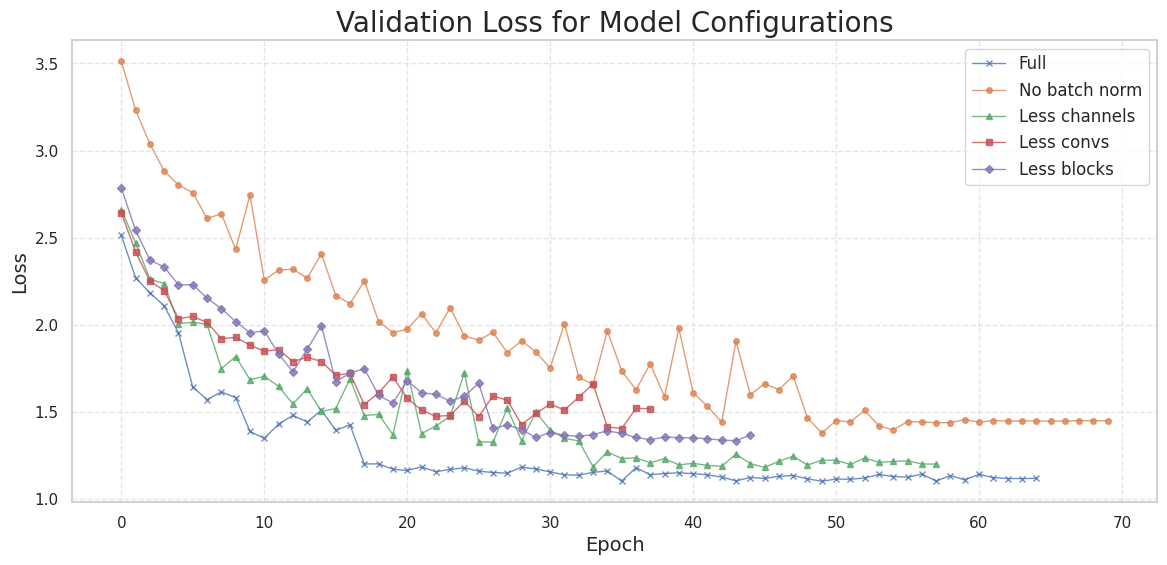

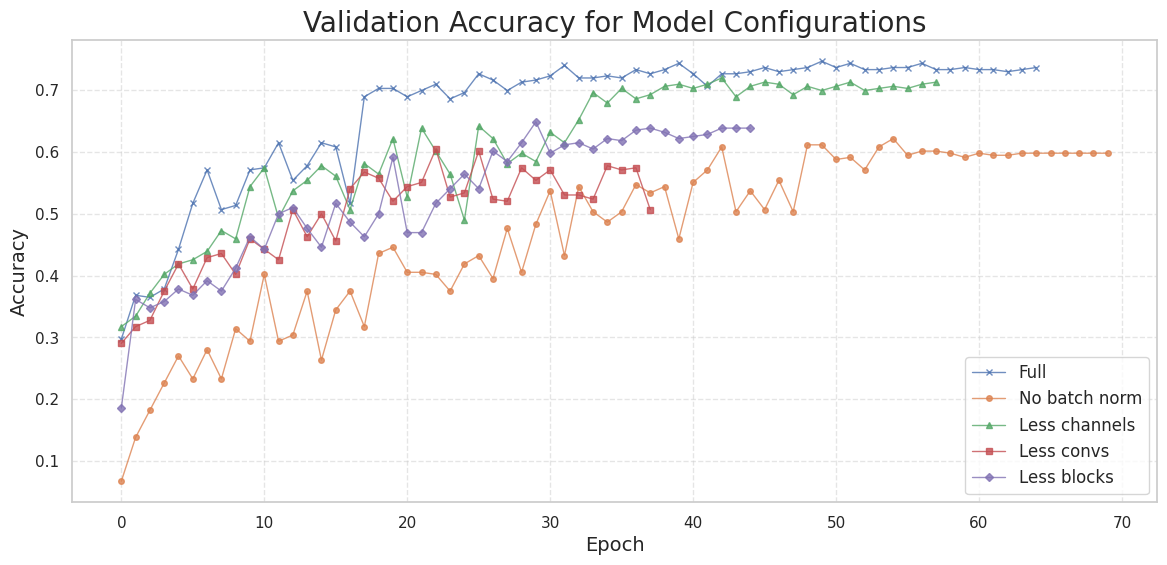

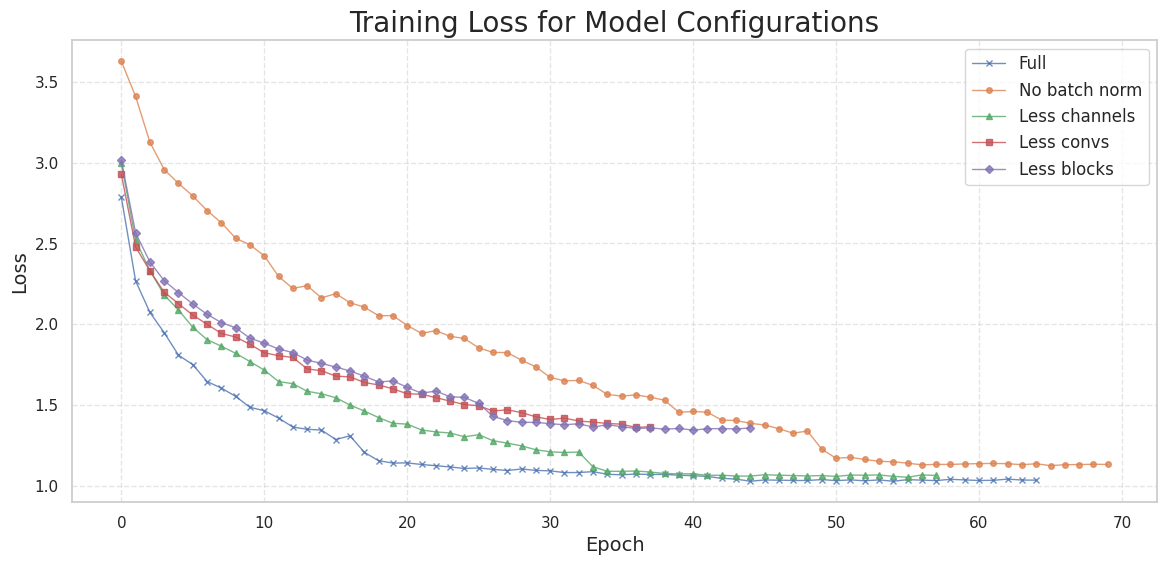

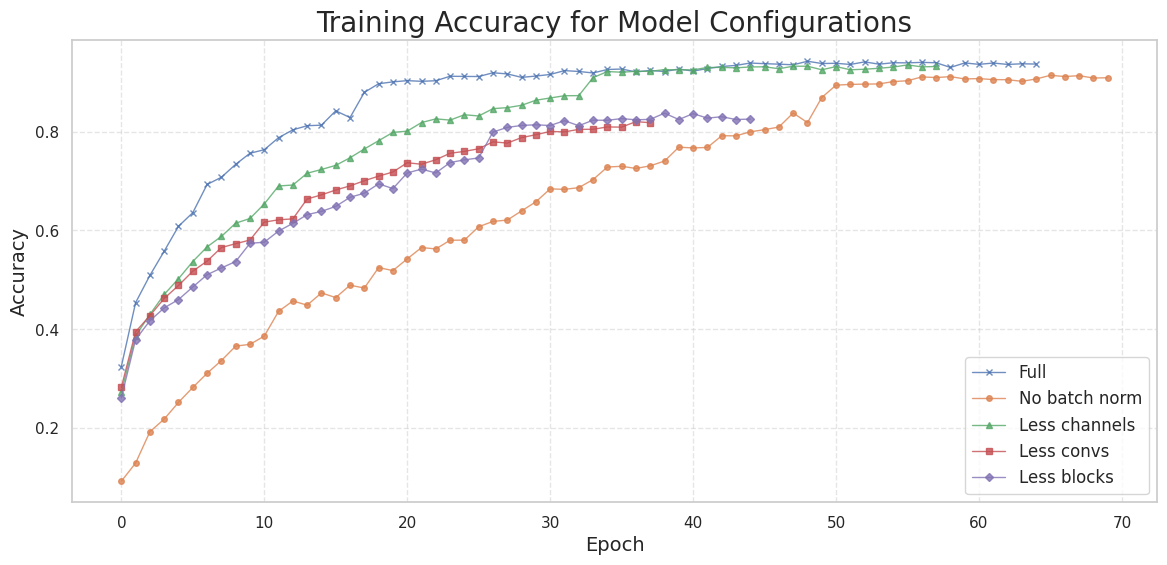

In [ ]:
def plot_metric(metrics: Dict[str, List[List[float]]],
                metric_id: int,
                title: str,
                ylabel: str,
                xlabel: str = 'Epoch',
                linewidth: float = 1,
                alpha: float = 0.8,
                figsize: Tuple[int, int] = (14,6)) -> None:
    """Function to plot Validation/Training Accuracy and Loss.

    Args:
        metrics: Dict[str, List[List[float]]]
            Dictionary containing data to be plotted.

        metric_id: int
            Index in the metrics dictionary to select the metric to be plotted.

        title: str
            Title of the plot.

        ylabel: str
            Label for the Y-axis.

        xlabel: str
            Label for the X-axis. Default: 'Epochs'

        linewidth: float
            Line width for the plot.

        alpha: float
            Transparency for lines and markers.

        figsize: Tuple[int, int]:
            Size of the figure. Default: (14,6)
    """

    plt.figure(figsize=figsize)

    # Set the title and axis labels
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Use a color palette and set marker types for different configurations
    colors = sns.color_palette()
    markers = ['x', 'o', '^', 's', 'D']

    # Plot each line for the different model configurations
    for i, key in enumerate(metrics.keys()):
        plt.plot(metrics[key][metric_id],
                 label=key,
                 color=colors[i],
                 linewidth=linewidth,
                 marker=markers[i],
                 markersize=4,
                 alpha=alpha)

    plt.legend(fontsize=12,frameon=True)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


plot_metric(metrics, 0, 'Validation Loss for Model Configurations', 'Loss')
plot_metric(metrics, 1, 'Validation Accuracy for Model Configurations', 'Accuracy')
plot_metric(metrics, 2, 'Training Loss for Model Configurations', 'Loss')
plot_metric(metrics, 3, 'Training Accuracy for Model Configurations', 'Accuracy')

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

## Default Hyperparameters

The `freezeLayer`function  makes sure that specific layers in the model are non trainable anymore.
In this setup, we freeze the lower layers in a ResNet-18 model pre-trained on ImageNet, while replacing the final fully connected layer `model.fc` to match the number of classes in our dataset. 

In [ ]:
def freezeLayer(layer):
    for param in layer.parameters():
        param.requires_grad = False
def unfreezeLayer(layer):
    for param in layer.parameters():
        param.requires_grad = True

In [ ]:
model = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, n_classes)
freezeLayer(model.conv1)
freezeLayer(model.bn1)
freezeLayer(model.layer1)
freezeLayer(model.layer2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We then train the model using default hyperparameters from `cfg`, tracking performance metrics like training and validation loss and accuracy.

In [ ]:
metrics = {}
optimizer = cfg['optimizer'](model.parameters(), **cfg['optimizer_params'])
scheduler = cfg['scheduler'](optimizer, **cfg['scheduler_params'])

metrics['Default'] = train_loop(
    model,
    train_dl,
    cfg['epochs'],
    cfg['patience'],
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 1.680, Train Acc: 0.709, Val Loss: 0.736, Val Acc: 0.834
Epoch 6/100: Train Loss: 0.781, Train Acc: 0.989, Val Loss: 0.791, Val Acc: 0.834
Epoch 11/100: Train Loss: 0.754, Train Acc: 0.994, Val Loss: 0.743, Val Acc: 0.885
Epoch 16/100: Train Loss: 0.742, Train Acc: 0.995, Val Loss: 0.703, Val Acc: 0.895
Epoch 21/100: Train Loss: 0.734, Train Acc: 0.997, Val Loss: 0.717, Val Acc: 0.868
Epoch 26/100: Train Loss: 0.720, Train Acc: 0.998, Val Loss: 0.712, Val Acc: 0.875
Epoch 31/100: Train Loss: 0.721, Train Acc: 0.998, Val Loss: 0.713, Val Acc: 0.875

Early stopping at epoch 35 with best val accuracy: 0.8986486486486487


## Tuned Hyperparameters

In this configuration, we fine-tune the ResNet-18 model with specific modifications to improve performance on the validation set:

1. **Fully Connected Layer with Dropout**:
   - The original fully connected (`fc`) layer is replaced with a `Sequential` block that includes a **Dropout layer (0.3)** followed by a fully connected layer. The Dropout layer helps reduce overfitting by randomly deactivating neurons during training, forcing the model to learn more robust features.

2. **Batch Size**:
    - We reduced the batch size from 64 to 32 in order to introduce more variability, which helps to prevent the model from overfitting.

In [ ]:
model = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, n_classes))
freezeLayer(model.conv1)
freezeLayer(model.bn1)
freezeLayer(model.layer1)
freezeLayer(model.layer2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
lr = 0.01
weight_decay = 0.001
epochs = 40
patience = 10
train_dl = DataLoader(augmented_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(),momentum=0.9,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

metrics['Tuned'] = train_loop(
    model,
    train_dl,
    epochs,
    patience,
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

Training progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40: Train Loss: 2.509, Train Acc: 0.430, Val Loss: 1.494, Val Acc: 0.628
Epoch 6/40: Train Loss: 0.944, Train Acc: 0.955, Val Loss: 0.607, Val Acc: 0.885
Epoch 11/40: Train Loss: 0.857, Train Acc: 0.979, Val Loss: 0.600, Val Acc: 0.885
Epoch 16/40: Train Loss: 0.837, Train Acc: 0.982, Val Loss: 0.561, Val Acc: 0.909
Epoch 21/40: Train Loss: 0.822, Train Acc: 0.985, Val Loss: 0.561, Val Acc: 0.905
Epoch 26/40: Train Loss: 0.830, Train Acc: 0.983, Val Loss: 0.579, Val Acc: 0.902
Epoch 31/40: Train Loss: 0.819, Train Acc: 0.986, Val Loss: 0.580, Val Acc: 0.909

Early stopping at epoch 34 with best val accuracy: 0.9155405405405406


## Plots

We initially had very good hyperparameters from the first part and while we experimented with several adjustments to improve performance, the only effective change was adding regularization. Although this slightly reduced training accuracy, as shown in the graphs below, it led to a bit of improvement in validation accuracy, indicating better generalization to unseen data.

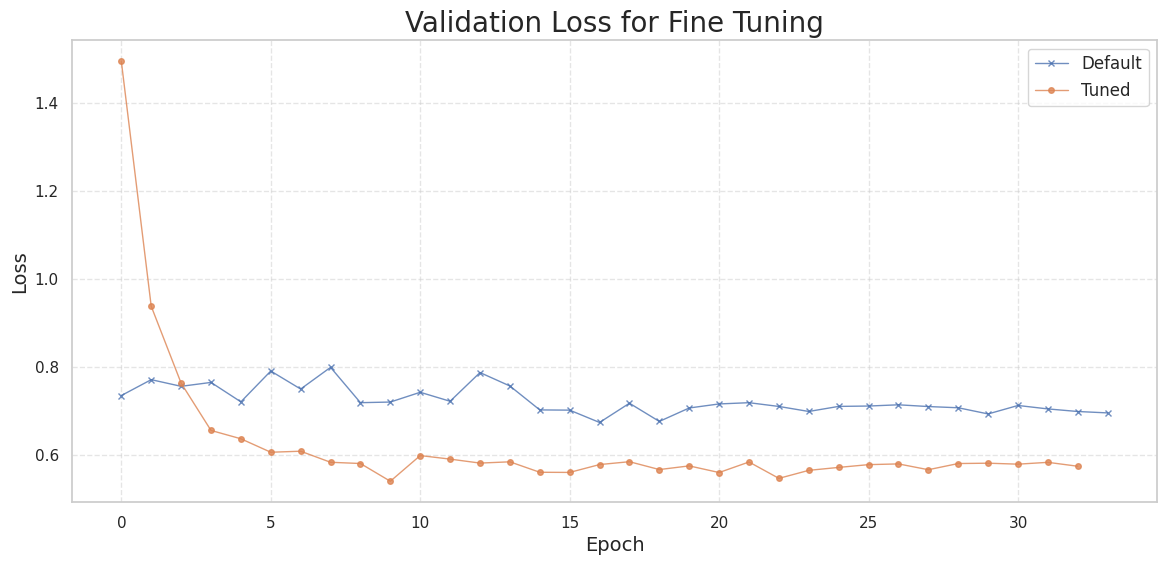

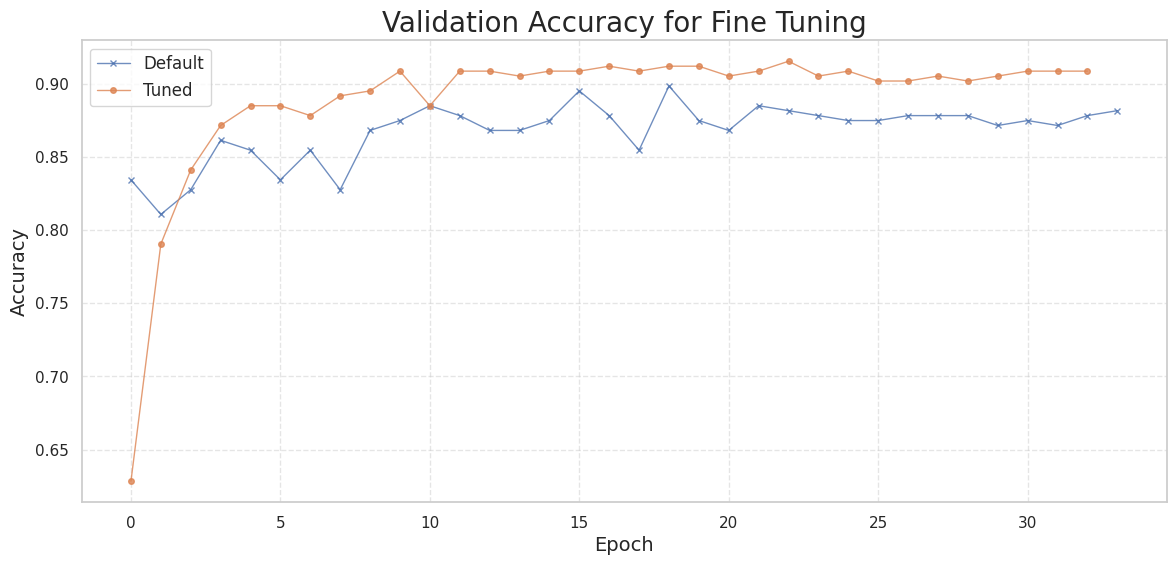

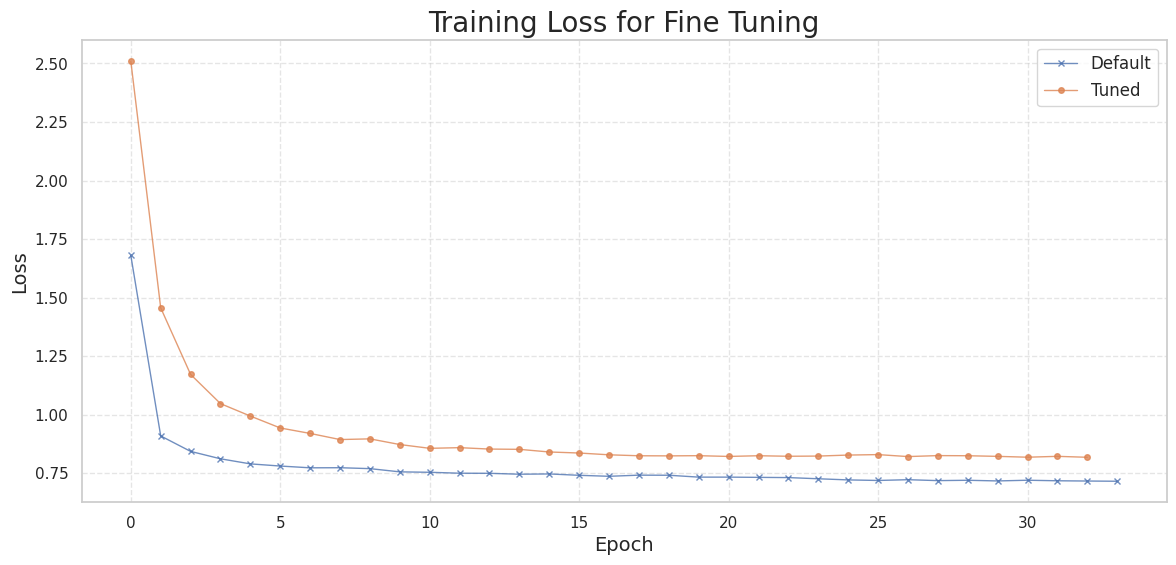

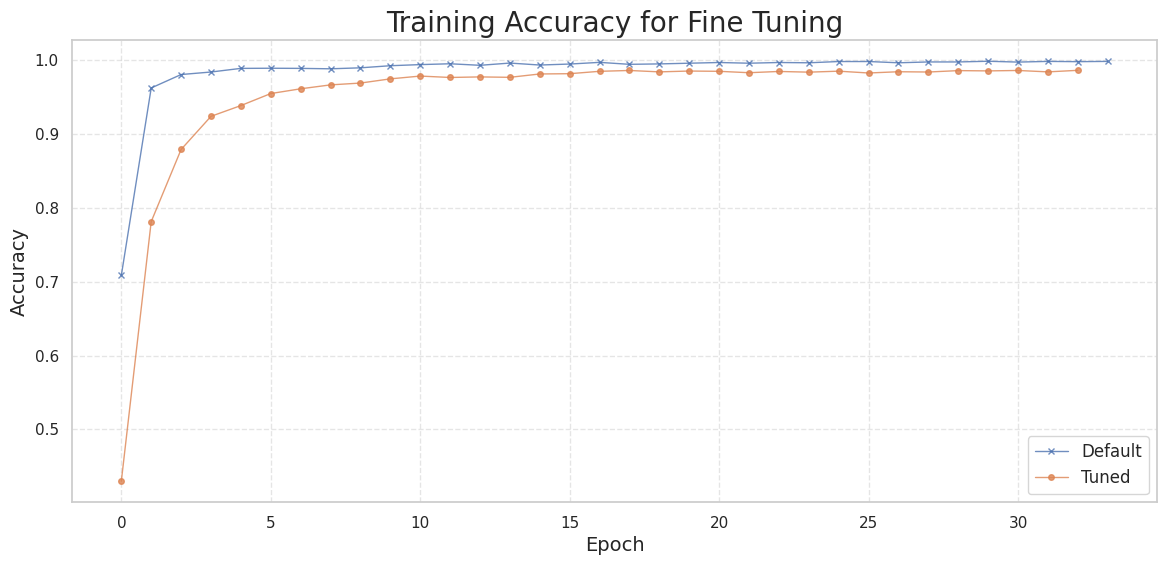

In [ ]:
plot_metric(metrics, 0, 'Validation Loss for Fine Tuning', 'Loss')
plot_metric(metrics, 1, 'Validation Accuracy for Fine Tuning', 'Accuracy')
plot_metric(metrics, 2, 'Training Loss for Fine Tuning', 'Loss')
plot_metric(metrics, 3, 'Training Accuracy for Fine Tuning', 'Accuracy')

# References

<a name="grocery-dataset">[1]</a> Mureșan, P., Oltean, S., & Leordeanu, M. (2020). [A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels](https://doi.org/10.48550/arXiv.1901.00711). Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2020.

<a name="resnet">[2]</a> He, K., Zhang, X., Ren, S., & Sun, J. (2016). [Deep Residual Learning for Image Recognition](
https://doi.org/10.48550/arXiv.1512.03385). Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778.

<a name="alexnet">[3]</a> Alex Krizhevsky, Ilya Sutskever, e Geoffrey E. Hinton, [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html), Advances in Neural Information Processing Systems, vol. 25, pp. 1097–1105, 2012.

<a name="vgg">[4]</a> Simonyan, K., & Zisserman, A. (2014). [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://doi.org/10.48550/arXiv.1409.1556). arXiv preprint arXiv:1409.1556.